# **Yolo v5 clone**

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (11695/11695), done.


In [2]:
%cd yolov5

/content/yolov5


# **필수 library 설치**

In [ ]:
!pip install -r requirements.txt

# **Set up**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import cv2
import numpy as np
import os
import random
import time

from collections import defaultdict

from IPython.display import display
from PIL import Image

from google.colab import files

import requests
import zipfile

from pycocotools.coco import COCO

!pip install roboflow
from roboflow import Roboflow

In [5]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Yolo v5 모델 불러오기**

In [66]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-27 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA L4, 22700MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# **Image 불러오기**

In [52]:
rf = Roboflow(api_key="ySEKEShsPx3kAF9OtPnl")
project = rf.workspace("projectsave").project("hard-hat-sample-sshkb")
version = project.version(1)
dataset = version.download("yolov5pytorch")

loading Roboflow workspace...
loading Roboflow project...


# **구글 드라이브 마운트**

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **구글 마이드라이브에 clone한 폴더 이동**

In [74]:
!cp -r /content/yolov5 /content/drive/MyDrive/

# **Model run()**

In [67]:
# 모든 레이어의 가중치 학습 가능하도록 설정
for name, param in model.named_parameters():
    param.requires_grad = True  # 모든 레이어의 학습 가능 설정

In [ ]:
# 각 레이어의 학습 가능 여부 확인
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
!python train.py --img 640 --batch 16 --epochs 20 --freeze 23 --data /content/yolov5/Hard-Hat-Sample-1/data.yaml --weights yolov5s.pt --cache

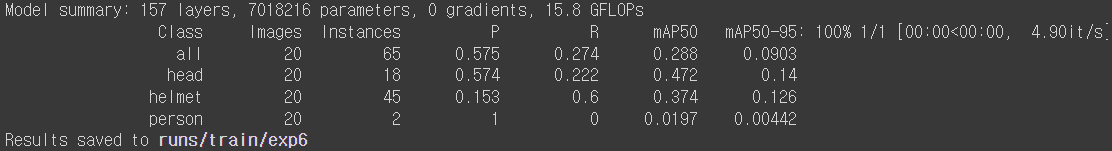

# **Test 이미지 모델에 입력 및 반환값 출력**

In [69]:
# 테스트할 이미지 경로 설정
test_images = '/content/yolov5/Hard-Hat-Sample-1/test/images/000008_jpg.rf.RB5mxZJIQ24B3RKrd9Lg.jpg'

# 이미지 로드 (BGR 형식으로 읽힘)
test_image = cv2.imread(test_images)

# 이미지가 정상적으로 로드되었는지 확인
if test_image is None:
    print(f"Error: Unable to load image at {test_images}")
else:
    print("Image loaded successfully!")

# 모델을 사용해 예측 수행
results = model(test_image)

Image loaded successfully!


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


# **탐지 결과 변형**

In [70]:
# 탐지된 결과를 numpy 배열로 변환
detections = results.xyxy[0].cpu().numpy()

# **결과 출력**

탐지된 객체 수: 9


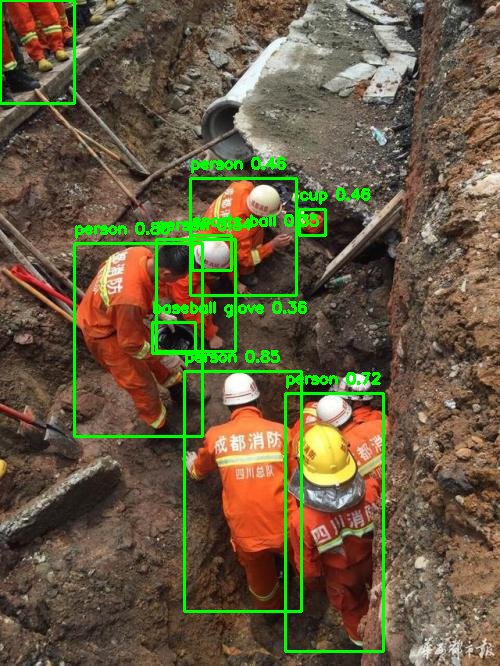

In [71]:
# 탐지된 객체가 있는지 확인
if len(detections) == 0:
    print("탐지된 객체가 없습니다.")
else:
    print(f"탐지된 객체 수: {len(detections)}")

    # 탐지된 객체에 대해 경계 상자 및 레이블 표시
    for detection in detections:
        x1, y1, x2, y2, conf, cls = detection[:6]
        label = f"{model.names[int(cls)]} {conf:.2f}"

        # 경계 상자 그리기
        cv2.rectangle(
            test_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2
        )

        # 레이블 표시
        cv2.putText(
            test_image, label, (int(x1), int(y1) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2
        )

    # BGR에서 RGB로 변환 (Matplotlib에서 올바르게 표시하기 위해)
    image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    image_pil = Image.fromarray(image_rgb)
    display(image_pil)